#### 6

In [1]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()
require(svMisc)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: svMisc

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



In [3]:
library(data.table)
library(hts)  


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [4]:
df_eu  <-  read.csv(file="../data_hts/hts_us_ind_filled.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2005   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [5]:
var_h  <- 8
var_window  <-  28 - 1
var_topup  <-  2
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [6]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0


var_arpdq   <-  c(4,1,1)
var_sarpdq   <-  c(0,0,0)
var_drift   <-  FALSE
var_constant   <-  FALSE

var_char  <-  c(2,3)

In [7]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)
# gts_train  <- window(y, start=19, end=46)
# gts_test  <- window(y, start=47, end=54)
# allts <- aggts(gts_train)
# allf <- matrix(, nrow=var_h, ncol=ncol(allts))

In [8]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = var_char)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]  1 28 29 36
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 50 1046 
Total number of series: 1097 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15889.06 15941.13 15974.38 15968.61 15957.79 15942.55 15927.59 15918.81
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 50 1046 
Total number of series: 1097 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15927.61 15976.18 15983.30 15994.87 16128.30 16136.38 16254.91 16372.60
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 32 33 40


Warning message in predict.Arima(object, n.ahead = h):
“MA part of model is not invertible”

Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 50 1046 
Total number of series: 1097 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15954.52 15905.72 15851.24 15802.02 15762.39 15734.96 15718.78 15713.08
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 50 1046 
Total number of series: 1097 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 33 
End = 40 
Frequency = 1 
[1] 16128.30 16136.38 16254.91 16372.60 16316.98 16522.48 16733.98 16809.04
[1]  9 36 37 44
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 50 1046 
Total number of series: 1097 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 16413.15 16446.24 16444.81 16433.51 16424.12 16414.40 16410.43 16409.05
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 50 1046 
Total number of series: 1097 
Num

In [9]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [10]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [11]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [12]:
df_acc

ME,RMSE,MAPE,Iteration
156.78337,218.86211,0.9656694,1
603.99455,682.95422,3.6534021,5
410.39342,500.96540,2.5571224,9
357.08663,389.24905,2.0677998,13
14.43914,45.53847,0.1944694,17
38.18337,80.04465,0.3471811,19


In [13]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 17234.12 17310.71 17383.43 17460.46 17536.56 17612.39 17688.49 17764.49

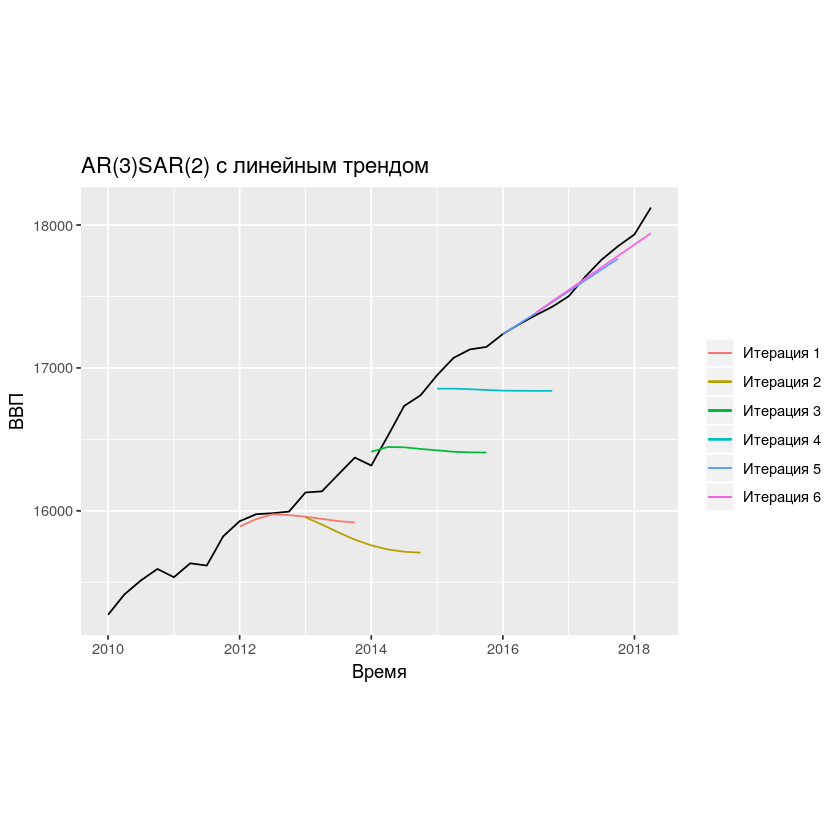

In [14]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [15]:
df_acc

ME,RMSE,MAPE,Iteration
156.78337,218.86211,0.9656694,1
603.99455,682.95422,3.6534021,5
410.39342,500.96540,2.5571224,9
357.08663,389.24905,2.0677998,13
14.43914,45.53847,0.1944694,17
38.18337,80.04465,0.3471811,19


In [16]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
263.480079 319.602316   1.630941  10.666667

In [17]:
df_mean_acc <- readRDS("df_mean_acc.rds")
rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.025,12274
3 level,83.34961,NA,NA
2 level (state),82.52303,NA,NA
2 level (type),81.81728,NA,NA
2 level (clusetered),82.25295,NA,NA


In [18]:
df_mean_acc[2,2]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274
3 level,83.34961,319.6023,NA
2 level (state),82.52303,NA,NA
2 level (type),81.81728,NA,NA
2 level (clusetered),82.25295,NA,NA


In [19]:
df_acc

ME,RMSE,MAPE,Iteration
156.78337,218.86211,0.9656694,1
603.99455,682.95422,3.6534021,5
410.39342,500.96540,2.5571224,9
357.08663,389.24905,2.0677998,13
14.43914,45.53847,0.1944694,17
38.18337,80.04465,0.3471811,19


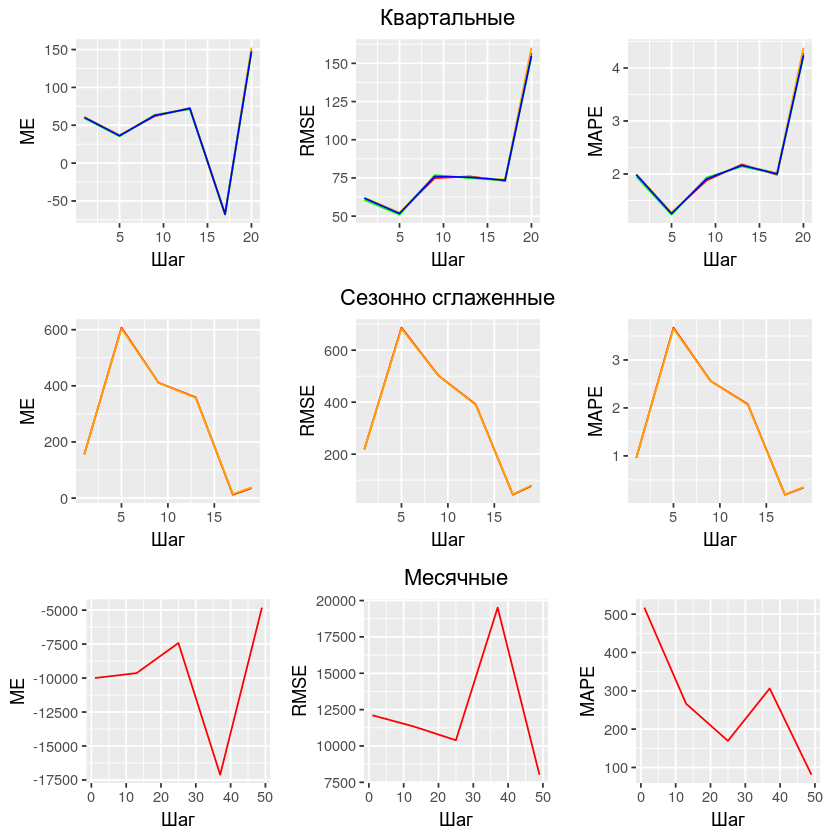

In [20]:
# Basic line plot with points

plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'orange'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 3
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 state

In [21]:
df_eu  <-  read.csv(file="../clustering/hts_us_ind_filled_state.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000


In [22]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [23]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [24]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
     
    
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]  1 28 29 36


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15889.10 15941.21 15974.47 15968.70 15957.88 15942.62 15927.65 15918.84
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15927.61 15976.18 15983.30 15994.87 16128.30 16136.38 16254.91 16372.60
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 32 33 40


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15954.49 15905.64 15851.10 15801.84 15762.16 15734.71 15718.52 15712.80
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 33 
End = 40 
Frequency = 1 
[1] 16128.30 16136.38 16254.91 16372.60 16316.98 16522.48 16733.98 16809.04
[1]  9 36 37 44


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 16413.18 16446.29 16444.85 16433.53 16424.12 16414.40 16410.41 16409.02
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 37 
End = 44 
Frequency = 1 
[1] 16316.98 16522.48 16733.98 16809.04 16949.40 17070.24 17129.69 17147.05
|[1] 13 40 41 48


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 16854.70 16855.31 16851.95 16847.13 16843.28 16842.98 16842.40 16843.05
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 41 
End = 48 
Frequency = 1 
[1] 16949.40 17070.24 17129.69 17147.05 17237.31 17306.78 17369.38 17427.95
|[1] 17 44 45 52


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 17233.75 17310.17 17382.33 17458.96 17534.50 17609.85 17685.29 17760.75
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 45 
End = 52 
Frequency = 1 
[1] 17237.31 17306.78 17369.38 17427.95 17501.51 17637.46 17757.34 17851.87
[1] 21 48 49 56


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 17385.37 17465.22 17543.85 17622.77 17701.77 17780.74 17859.61 17938.55
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 50 
Total number of series: 51 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 47 
End = 54 
Frequency = 1 
[1] 17369.38 17427.95 17501.51 17637.46 17757.34 17851.87 17934.57 18122.00


In [25]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [26]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [27]:
df_acc

ME,RMSE,MAPE,Iteration
156.71173,218.82104,0.9652237,1
604.17615,683.15265,3.6545021,5
410.38092,500.96789,2.5570854,9
357.12655,389.30246,2.0680297,13
14.24941,45.41366,0.1942407,17
38.02456,79.90199,0.3465944,19


In [28]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 17234.13 17310.71 17383.43 17460.46 17536.57 17612.40 17688.49 17764.50

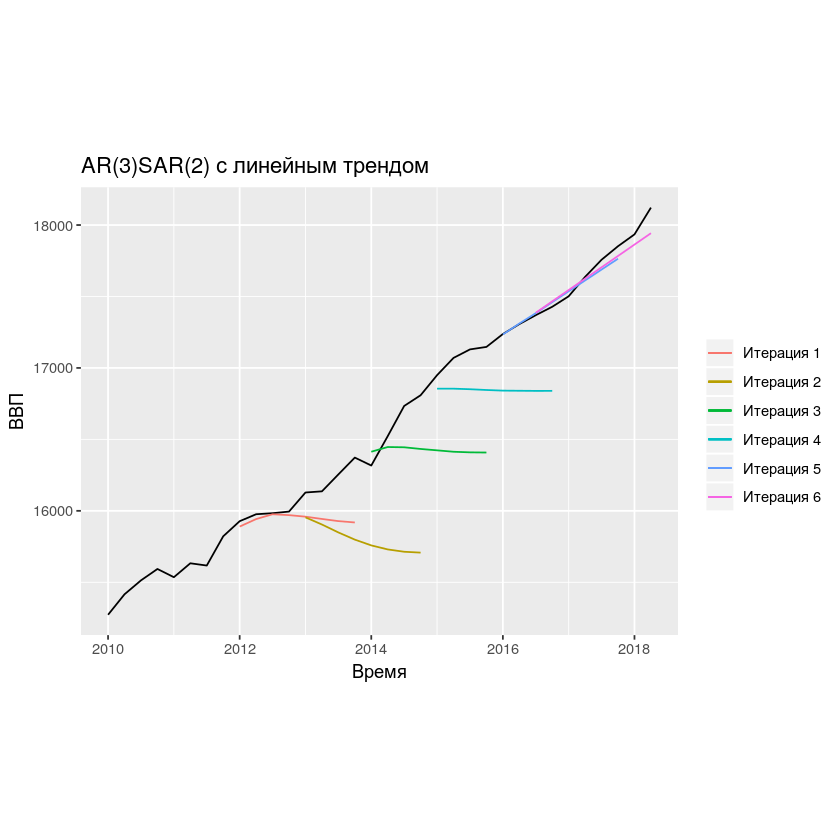

In [29]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [30]:
colMeans(df_acc)
df_mean_acc

ME       RMSE       MAPE  Iteration 
263.444887 319.593281   1.630946  10.666667

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274
3 level,83.34961,319.6023,NA
2 level (state),82.52303,NA,NA
2 level (type),81.81728,NA,NA
2 level (clusetered),82.25295,NA,NA


In [31]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [32]:
df_mean_acc[3,2]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274
3 level,83.34961,319.6023,NA
2 level (state),82.52303,319.5933,NA
2 level (type),81.81728,NA,NA
2 level (clusetered),82.25295,NA,NA


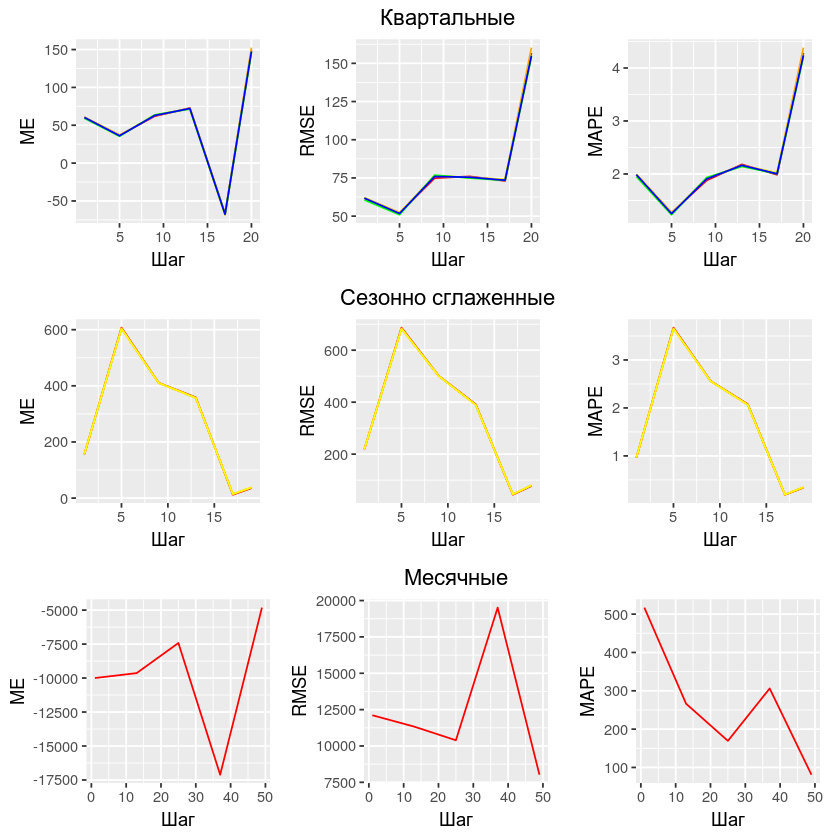

In [33]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'yellow'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 3
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 type

In [34]:
df_eu  <-  read.csv(file="../clustering/hts_us_ind_filled_type.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000


In [35]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [36]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [37]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]  1 28 29 36


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15888.98 15939.62 15971.73 15965.78 15953.88 15939.58 15924.29 15915.89
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15927.61 15976.18 15983.30 15994.87 16128.30 16136.38 16254.91 16372.60
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 32 33 40


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15956.38 15908.61 15855.58 15807.90 15769.61 15742.80 15727.35 15722.05
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 33 
End = 40 
Frequency = 1 
[1] 16128.30 16136.38 16254.91 16372.60 16316.98 16522.48 16733.98 16809.04
[1]  9 36 37 44


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 16411.23 16443.39 16441.66 16430.34 16421.47 16412.18 16407.73 16407.01
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 37 
End = 44 
Frequency = 1 
[1] 16316.98 16522.48 16733.98 16809.04 16949.40 17070.24 17129.69 17147.05
|[1] 13 40 41 48


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 16854.08 16852.54 16847.13 16841.17 16837.00 16837.31 16837.49 16839.19
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 41 
End = 48 
Frequency = 1 
[1] 16949.40 17070.24 17129.69 17147.05 17237.31 17306.78 17369.38 17427.95
|[1] 17 44 45 52


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 17233.02 17307.83 17380.19 17456.42 17531.62 17606.26 17680.68 17754.75
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 45 
End = 52 
Frequency = 1 
[1] 17237.31 17306.78 17369.38 17427.95 17501.51 17637.46 17757.34 17851.87
[1] 21 48 49 56


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 17385.07 17462.98 17542.67 17619.30 17697.11 17774.23 17852.82 17929.98
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 21 
Total number of series: 22 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 47 
End = 54 
Frequency = 1 
[1] 17369.38 17427.95 17501.51 17637.46 17757.34 17851.87 17934.57 18122.00


In [38]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [39]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [40]:
df_acc

ME,RMSE,MAPE,Iteration
159.30212,221.03865,0.9812803,1
598.04966,676.58618,3.6173688,5
412.98087,503.07024,2.5695461,9
361.48657,393.71353,2.0933215,13
17.35356,47.61154,0.1976449,17
42.24041,84.19349,0.3648724,19


In [41]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 17234.17 17310.80 17383.55 17460.62 17536.76 17612.62 17688.74 17764.78

In [42]:
gdp_agg

         Qtr1     Qtr2     Qtr3     Qtr4
2005 14810.82 14901.49 15022.51 15101.40
2006 15314.55 15358.25 15361.53 15464.20
2007 15476.48 15549.12 15617.51 15731.15
2008 15625.38 15697.53 15581.97 15215.99
2009 15077.69 15056.99 15107.67 15245.91
2010 15272.78 15415.95 15513.26 15593.13
2011 15535.51 15632.94 15617.13 15821.82
2012 15927.61 15976.18 15983.30 15994.87
2013 16128.30 16136.38 16254.91 16372.60
2014 16316.98 16522.48 16733.98 16809.04
2015 16949.40 17070.24 17129.69 17147.05
2016 17237.31 17306.78 17369.38 17427.95
2017 17501.51 17637.46 17757.34 17851.87
2018 17934.57 18122.00                  

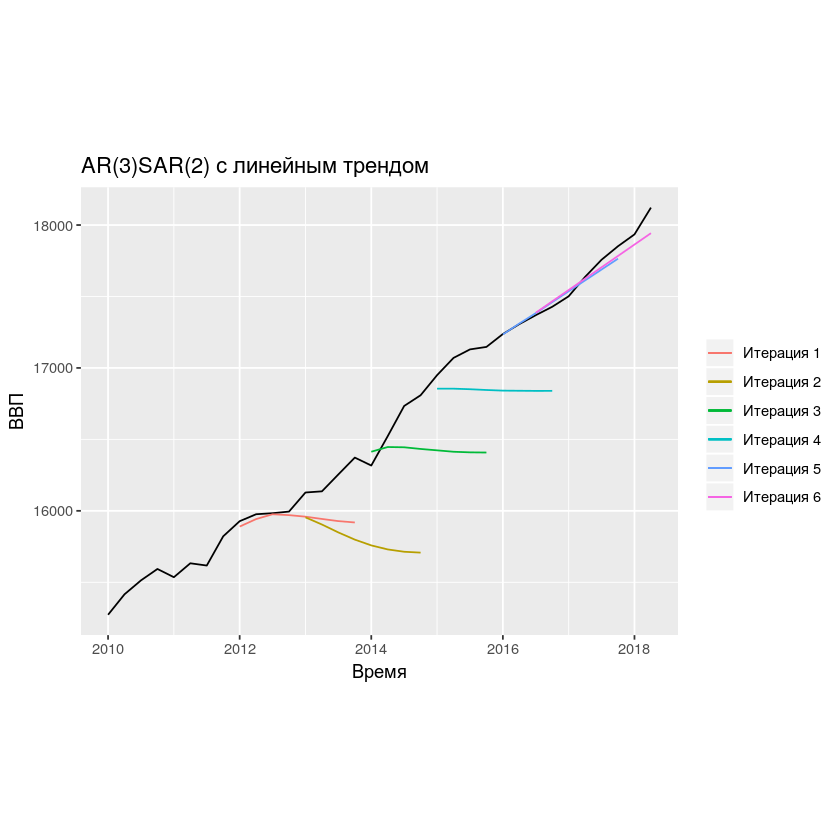

In [43]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [44]:
colMeans(df_acc)

ME       RMSE       MAPE  Iteration 
265.235530 321.035605   1.637339  10.666667

In [45]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [46]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274
3 level,83.34961,319.6023,NA
2 level (state),82.52303,319.5933,NA
2 level (type),81.81728,NA,NA
2 level (clusetered),82.25295,NA,NA


In [47]:
df_mean_acc[4,2]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274
3 level,83.34961,319.6023,NA
2 level (state),82.52303,319.5933,NA
2 level (type),81.81728,321.0356,NA
2 level (clusetered),82.25295,NA,NA


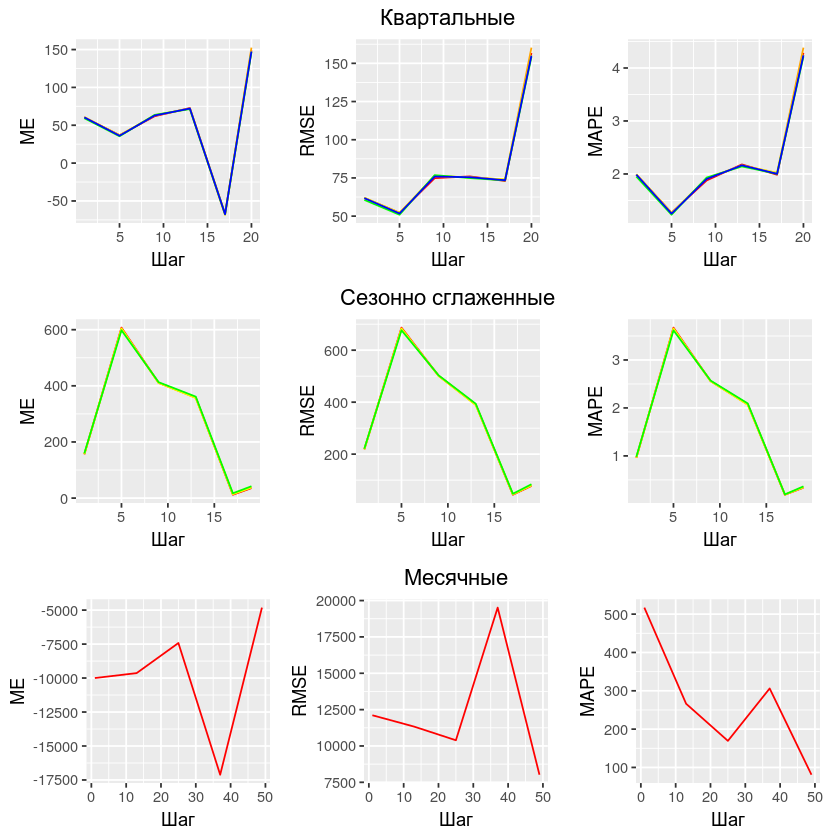

In [48]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'green'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 3
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 clust

In [49]:
df_eu  <-  read.csv(file="../clustering/hts_us_ind_filled_clust.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000


In [50]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

In [51]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(y)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [52]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- tryCatch(        
        Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq,  include.drift = var_drift, include.mean = var_constant, method="ML"), 
            error = function(e) 
#                               {tryCatch( 
                Arima(msts(allts[,j], seasonal.periods = var_freq), order=var_arpdq, seasonal=var_sarpdq, include.drift = var_drift, include.mean = var_constant, method="CSS") #,
#                          error = function(e)              
#                             auto.arima(msts(allts[,j], seasonal.periods = var_freq))
#                          )}
                        
            )
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]  1 28 29 36


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15889.58 15942.67 15976.03 15971.67 15961.37 15947.35 15932.76 15924.57
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15927.61 15976.18 15983.30 15994.87 16128.30 16136.38 16254.91 16372.60
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 32 33 40


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 15956.55 15909.23 15856.95 15809.25 15771.25 15744.46 15729.12 15723.60
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 33 
End = 40 
Frequency = 1 
[1] 16128.30 16136.38 16254.91 16372.60 16316.98 16522.48 16733.98 16809.04
[1]  9 36 37 44


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 16414.55 16447.12 16446.56 16435.95 16427.58 16418.27 16415.10 16414.40
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 37 
End = 44 
Frequency = 1 
[1] 16316.98 16522.48 16733.98 16809.04 16949.40 17070.24 17129.69 17147.05
|[1] 13 40 41 48


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 16854.49 16855.13 16851.80 16847.42 16844.05 16844.59 16844.64 16845.81
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 41 
End = 48 
Frequency = 1 
[1] 16949.40 17070.24 17129.69 17147.05 17237.31 17306.78 17369.38 17427.95
|[1] 17 44 45 52


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 17232.39 17308.19 17379.31 17455.98 17530.77 17605.59 17679.96 17753.89
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 45 
End = 52 
Frequency = 1 
[1] 17237.31 17306.78 17369.38 17427.95 17501.51 17637.46 17757.34 17851.87
[1] 21 48 49 56


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 29 
End = 36 
Frequency = 1 
[1] 17385.18 17464.36 17543.20 17621.06 17699.57 17777.68 17855.61 17933.58
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 47 
End = 54 
Frequency = 1 
[1] 17369.38 17427.95 17501.51 17637.46 17757.34 17851.87 17934.57 18122.00


In [53]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [54]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [55]:
df_acc

ME,RMSE,MAPE,Iteration
153.52240,215.42908,0.9455024,1
596.78133,675.26550,3.6096729,5
407.41468,497.71650,2.5417078,9
356.23334,388.07147,2.0628901,13
17.94082,47.91991,0.1983896,17
40.22965,82.28054,0.3564950,19


In [56]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 17234.10 17310.66 17383.35 17460.37 17536.46 17612.27 17688.34 17764.34

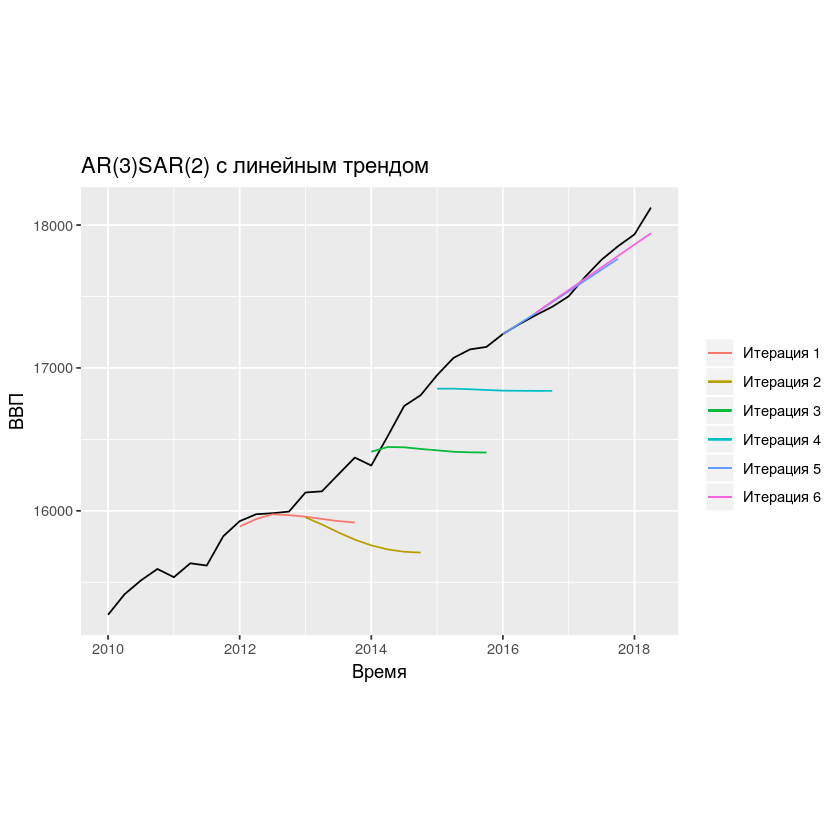

In [57]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [58]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
262.02037 317.78050   1.61911  10.66667

In [59]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [60]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274
3 level,83.34961,319.6023,NA
2 level (state),82.52303,319.5933,NA
2 level (type),81.81728,321.0356,NA
2 level (clusetered),82.25295,NA,NA


In [61]:
df_mean_acc[5,2]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,82.46349,320.0250,12274
3 level,83.34961,319.6023,NA
2 level (state),82.52303,319.5933,NA
2 level (type),81.81728,321.0356,NA
2 level (clusetered),82.25295,317.7805,NA


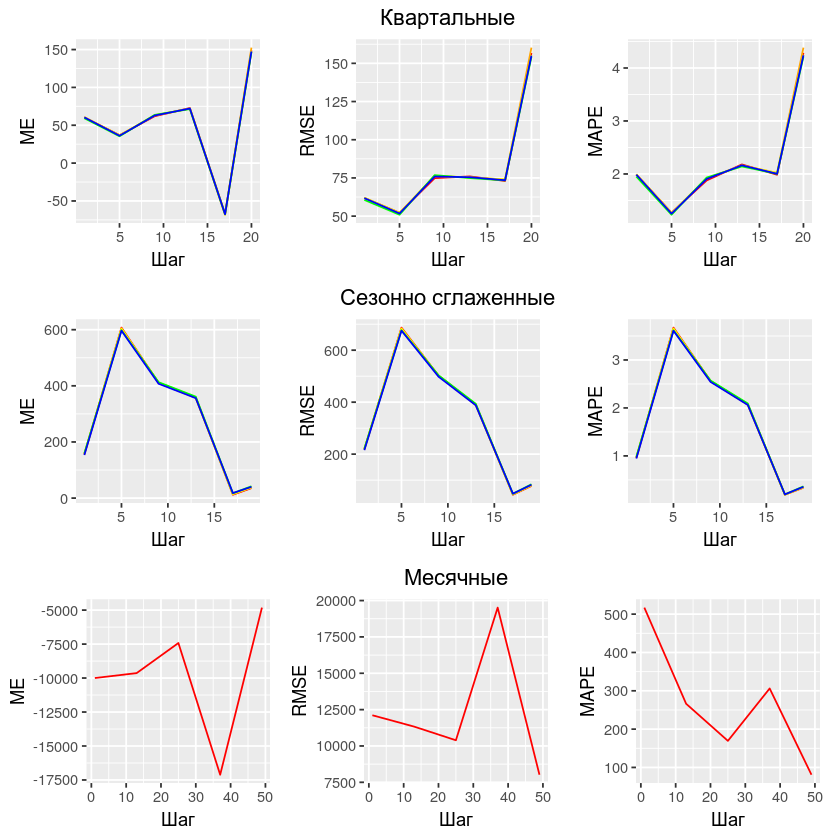

In [62]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'blue'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 3
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

In [63]:
saveRDS(df_mean_acc, "df_mean_acc.rds")
saveRDS(plots_test_all, "plots_test_not_all.rds")